In [1]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_context('paper')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [57]:
import os
import sys
import copy
from pprint import pprint

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer

dump_dir = os.path.abspath('../.log')

def parse_dump(dump):
    ts = dump.get('ts')
#     z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
    true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, pred_zt, true_zt_chaos

def download_runs_sweep(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        
        for f in run.files():
            if f.name != 'data.pt' and f.name != 'model.pt':
                continue
        
            fpath = os.path.join(download_root, f.name)
            if not os.path.isfile(fpath):
                f.download(root=download_root)
                
            if f.name == 'data.pt':
                data = torch.load(fpath)
            else:
                model = torch.load(fpath, map_location=torch.device('cpu'))
            
        yield run.name, run.config, model, parse_dump(data)

de_run_id = ["1axj7lqk"]

for _, cfg, model_dict, (ts, true_zt, pred_zt, true_zt_chaos) in download_runs_sweep(de_run_id):
    pass

cfg.pop('uq_type')
cfg.pop('C')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body)
trainer.model.load_state_dict(model_dict)

<All keys matched successfully>

In [68]:
import torch
import torch.nn as nn
from torchdiffeq import odeint  # odeint_adjoint as odeint
import numpy as np
from oil.utils.utils import export


@export
class LyapunovDynamics(nn.Module):
    def __init__(self, F):
        super().__init__()
        self.F = F

    def forward(self, t, xqr):
        """ Computes a batch of `NxD` time derivatives of the state `xqr` at time `t`
        Args:
            t: Scalar Tensor of the current time
            z: N x D Tensor of the N different states in D dimensions
        """
        assert (t.ndim == 0) and (xqr.ndim == 2)
        n = (xqr.shape[-1] - 1) // 2
        with torch.enable_grad():
            x = xqr[..., :n] + torch.zeros_like(xqr[..., :n], requires_grad=True)
            q = xqr[..., n : 2 * n]
            xdot = self.F(t, x)
            DFq = vjp(xdot, x, q)
        qDFq = (q * DFq).sum(-1, keepdims=True)
        qdot = DFq - q * qDFq
        lrdot = qDFq
        xqrdot = torch.cat([xdot, qdot, lrdot], dim=-1)
        return xqrdot


def MLE(xt, ts, F, v0=None):
    """ Computes the Maximal Lyapunov exponent using the Power iteration.
        inputs: trajectory [xt (T,*)] dynamics [F] """
    v = torch.randn_like(xt[0]) if v0 is None else v0
    dt = ts[1] - ts[0]
    exps = []
    for i, x in enumerate(xt):
        for j in range(8):
            x = torch.zeros_like(x, requires_grad=True) + x.detach()
            y = F(ts[i], x[None])[0]
            u = v + vjp(y, x, v).detach() * dt
            # u  = v+ dt*(F(ts[i],(x+1e-7*v)[None])[0]-F(ts[i],x[None])[0])/(1e-7)
            r = (u ** 2).sum().sqrt().detach()
            v = u / r  # P((u/r)[None,:,None])[0,:,0]
        exps += [r.log().item() / dt]  # (1/i)*(r.log() - exp)
        # print(r.log()/(100/5000))
    return np.array(exps)  # ,u


def MLE2(x0, F, ts, **kwargs):
    with torch.no_grad():
        LD = LyapunovDynamics(F)
        x0 = x0.reshape(x0.shape[0], -1)
        q0 = torch.randn_like(x0)
        q0 /= (q0 ** 2).sum(-1, keepdims=True).sqrt()
        lr0 = torch.zeros(x0.shape[0], 1, dtype=x0.dtype, device=x0.device)
        Lx0 = torch.cat([x0, q0, lr0], dim=-1)
        Lxt = odeint(LD, Lx0, ts, **kwargs)
        maximal_exponent = Lxt  # [...,-1]
    return maximal_exponent


def jvp(y, x, v):
    with torch.enable_grad():
        Jv = torch.autograd.grad(y, [x], [v])[0]
    return Jv


def vjp(y, x, v):
    # Following the trick from https://j-towns.github.io/2017/06/12/A-new-trick.html
    with torch.enable_grad():
        u = torch.ones_like(
            y, requires_grad=True
        )  # Dummy variable (could take any value)
        Ju = torch.autograd.grad(y, [x], [u], create_graph=True)[0]
        vJ = torch.autograd.grad(Ju, [u], [v])[0]
    return vJ

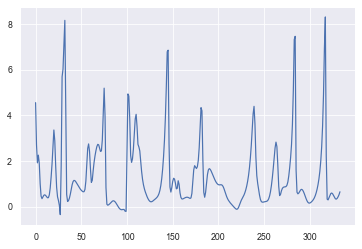

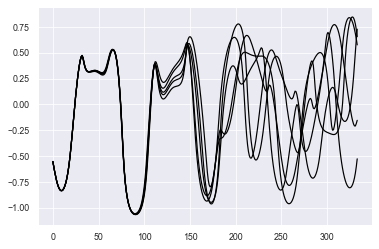

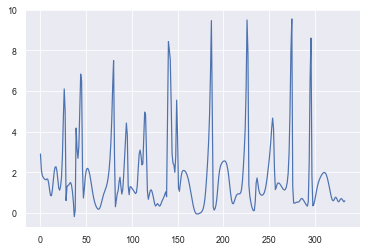

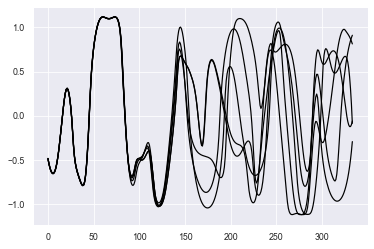

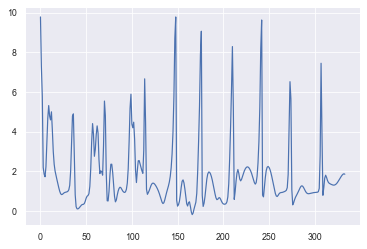

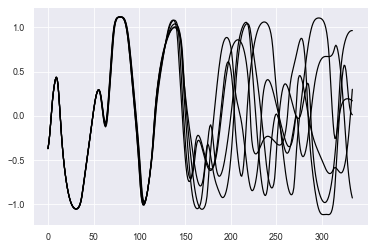

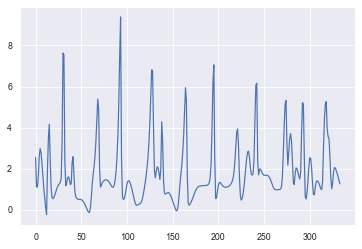

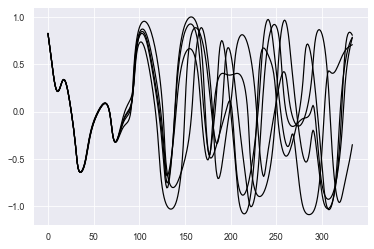

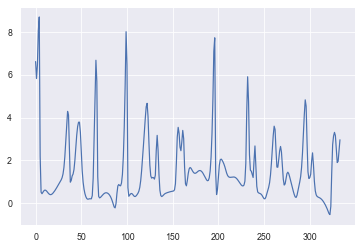

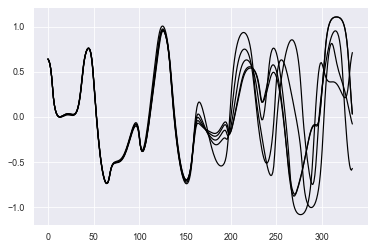

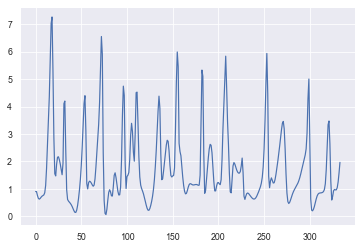

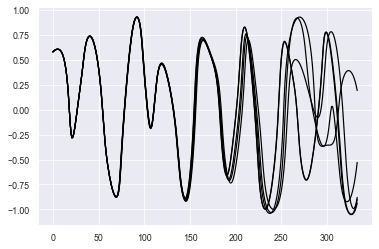

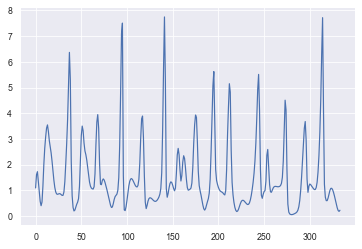

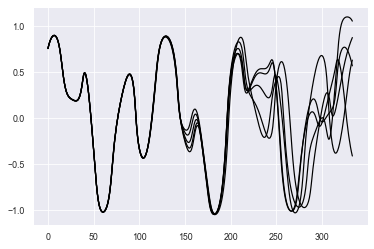

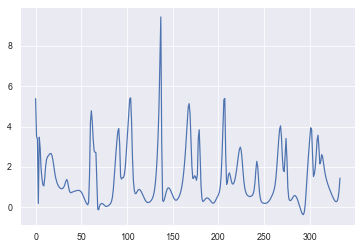

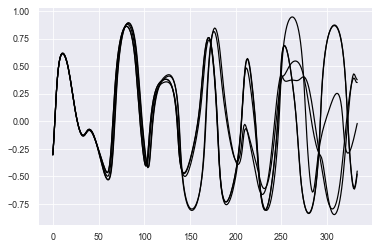

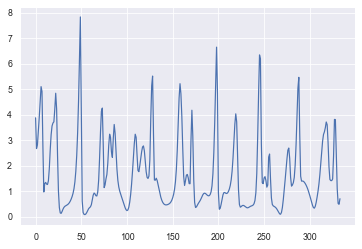

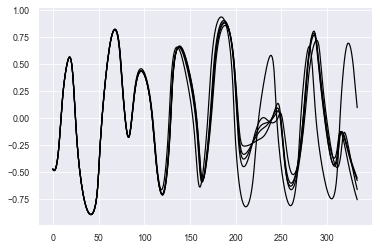

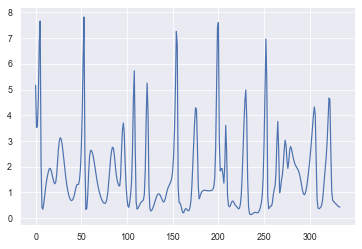

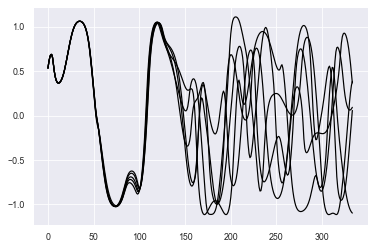

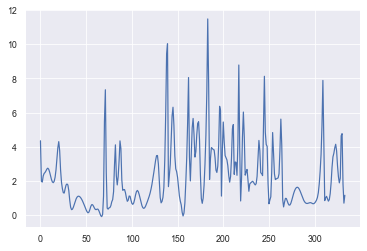

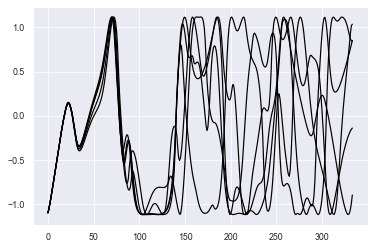

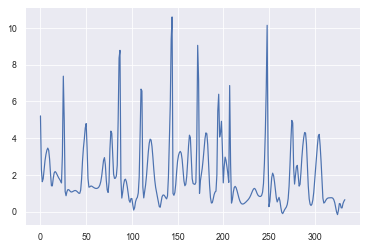

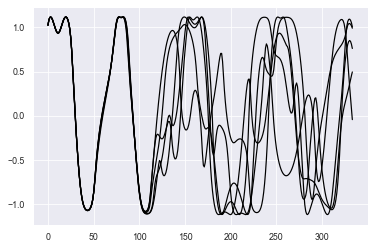

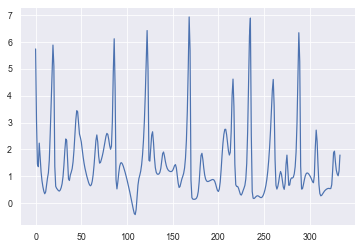

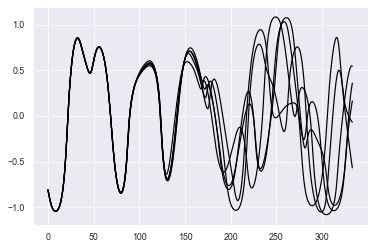

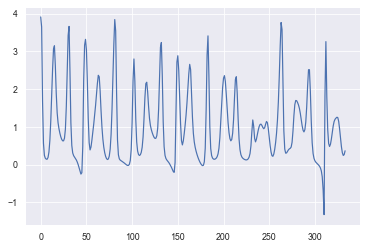

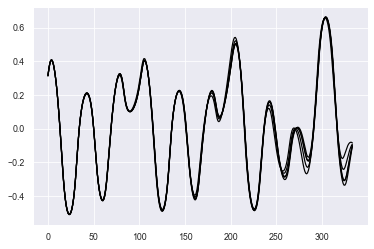

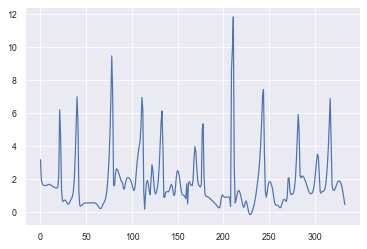

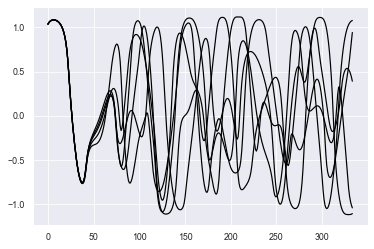

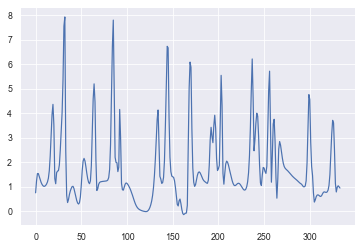

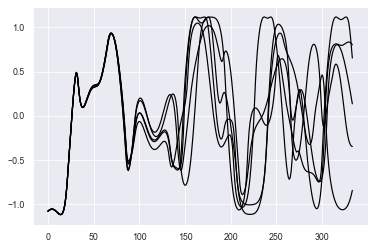

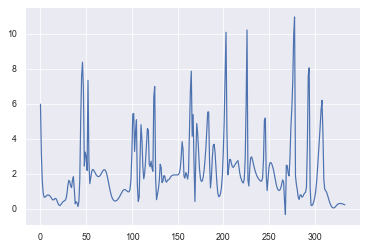

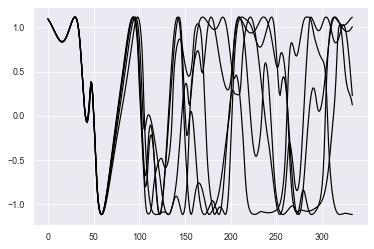

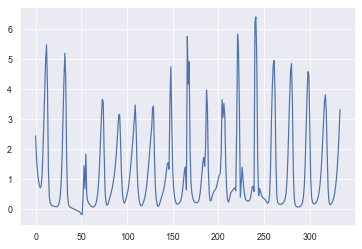

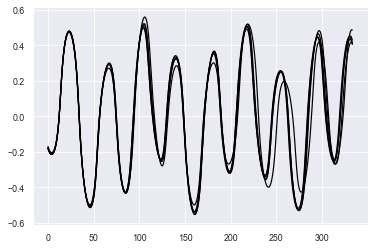

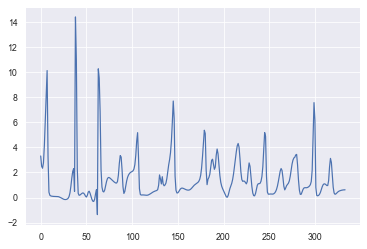

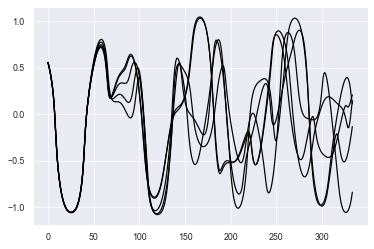

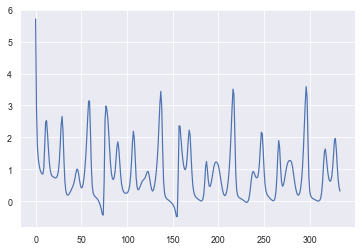

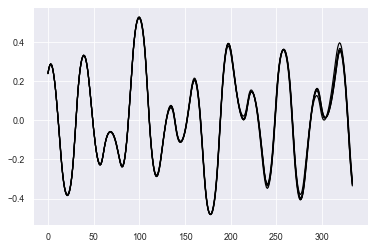

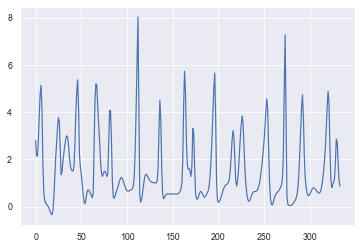

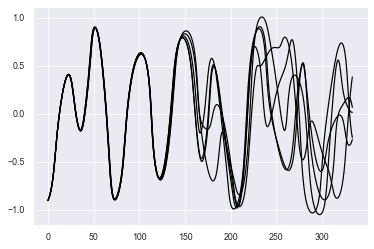

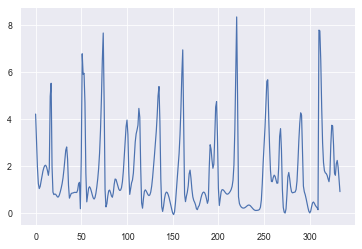

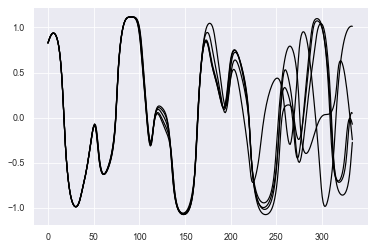

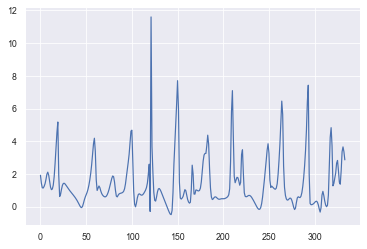

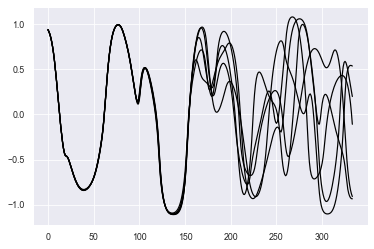

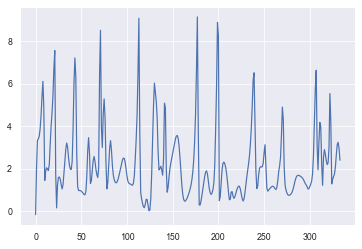

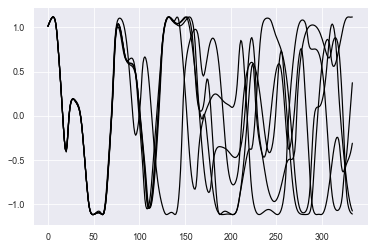

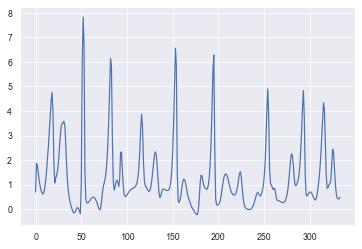

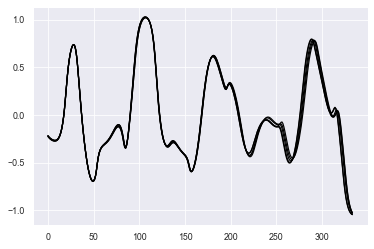

In [69]:
for i in range(25):
    xt = body.to_pos_momentum(true_zt.reshape(-1, *true_zt.shape[2:]))
    xt = xt.reshape(*true_zt.shape[:2], xt.shape[1])[i]

# #     for i in range(2):
    lyapunov_exponent = MLE(xt, ts, body.dynamics())
    plt.plot(range(len(lyapunov_exponent)), lyapunov_exponent)
    plt.show()

    T = true_zt.shape[1]
    for y_gt in true_zt_chaos[:, i, :, 0, 0, 0]:
        plt.plot(range(T), y_gt, color='black')
    plt.show()
    plt.close()
    
# exps = []
# for i in range(5):
#     lyapunov_exponent = MLE(x0, body.dynamics(), ts)
#     exps.append(lyapunov_exponent)
# print(np.stack(exps, axis=0).var(axis=0))    
# print(np.stack(exps, axis=0).mean(axis=0))

In [33]:
# print(np.stack(exps, axis=0).mean(1).var(axis=0))    
print(x0.shape)
print(np.stack(exps, axis=0).mean(1).mean(axis=0).shape)

torch.Size([25, 12])
(25, 25)


In [ ]:
def get_preds(model, loader):
    preds = []
    for (z0, ts), true_zs in loader:
        with torch.no_grad():
            xp0 = model.to_pos_momentum(z0)
            t0 = ts[0,0]
            preds.append(model.dynamics(t0,xp0))
    preds = torch.cat(preds, dim=0)
    return preds

def get_ensemble_preds(ensemble, loader):
    preds = []
    for model in ensemble:
        preds.append(get_preds(model, loader).flatten())
    preds = torch.stack(preds, dim=0)
    return preds
        
log_dir = os.path.join(os.environ["LOGDIR"], "CHNN_ensembles")

train_loader = copy.deepcopy(trainer._trainers[0].dataloaders["train"])
test_loader = copy.deepcopy(trainer._trainers[0].dataloaders["test"])

train_preds = []
test_preds = []

train_preds.append(get_ensemble_preds(trainer.ensemble, train_loader))
test_preds.append(get_ensemble_preds(trainer.ensemble, test_loader))

for epoch_step in range(100):
    save_fn = "ensemble_epoch_{}.pt".format(5 * epoch_step)
    
    if False:# os.path.exists(save_fn):
        ensemble_dict = torch.load(save_fn)
        trainer.ensemble.load_state_dict(ensemble_dict)
    else:
        trainer.train(1)
        torch.save(trainer.ensemble.state_dict(), save_fn)
    
    train_preds.append(get_ensemble_preds(trainer.ensemble, train_loader))
    test_preds.append(get_ensemble_preds(trainer.ensemble, test_loader))

train_preds = torch.stack(train_preds, dim=0)
test_preds = torch.stack(test_preds, dim=0)

print(train_preds.size())
print(test_preds.size())

In [14]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_embeddings(preds):
    preds = np.stack([x for idx, x in enumerate(preds.swapaxes(0,1)) if idx != 3], axis=1)
    
    unflat_size = preds.shape
    flat_train_preds = preds.reshape((-1, unflat_size[-1]))
    
    reducer = umap.UMAP()
    scaled_preds = StandardScaler().fit_transform(flat_train_preds)
    embedding = reducer.fit_transform(scaled_preds)
    embedding = embedding.reshape((unflat_size[0], unflat_size[1], -1))
    embedding = embedding.swapaxes(0, 1)
    
    return embedding

train_embeddings = get_embeddings(train_preds.cpu().detach().numpy())
test_embeddings = get_embeddings(test_preds.cpu().detach().numpy())

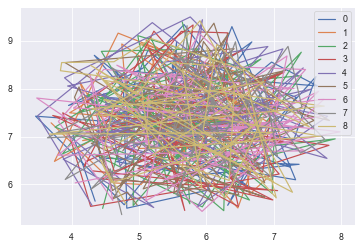

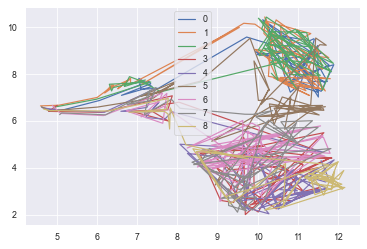

In [15]:
def plot_embeddings(embeddings):
    for idx, m_embeddings in enumerate(embeddings):
        plt.plot(m_embeddings[:,0], m_embeddings[:,1], label=str(idx))
    plt.legend()
    plt.show()
    plt.close()

plot_embeddings(train_embeddings)
plot_embeddings(test_embeddings)

In [3]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


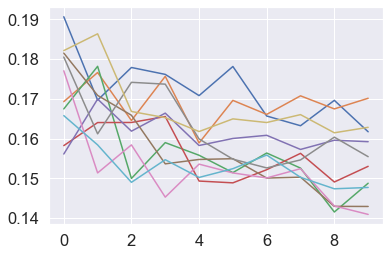

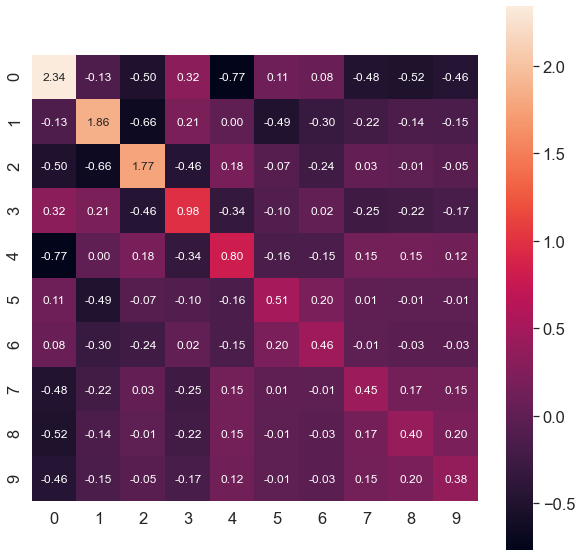

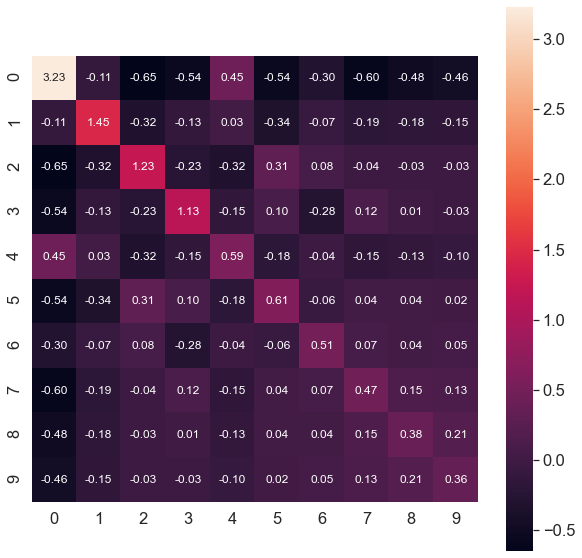

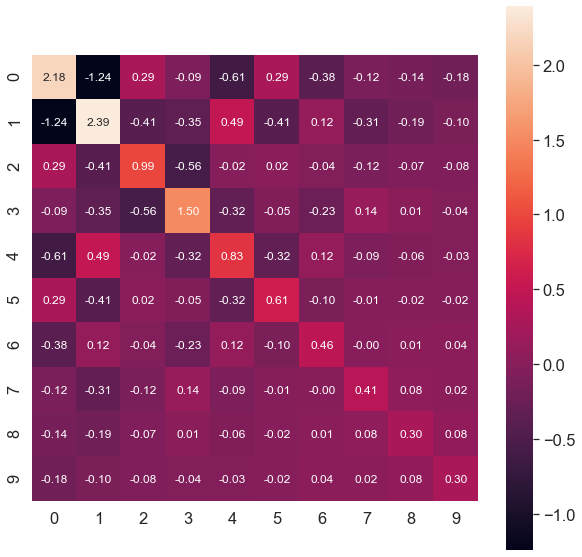

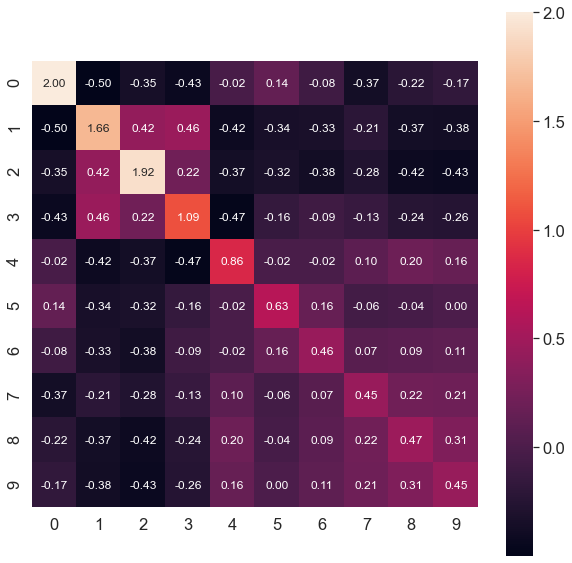

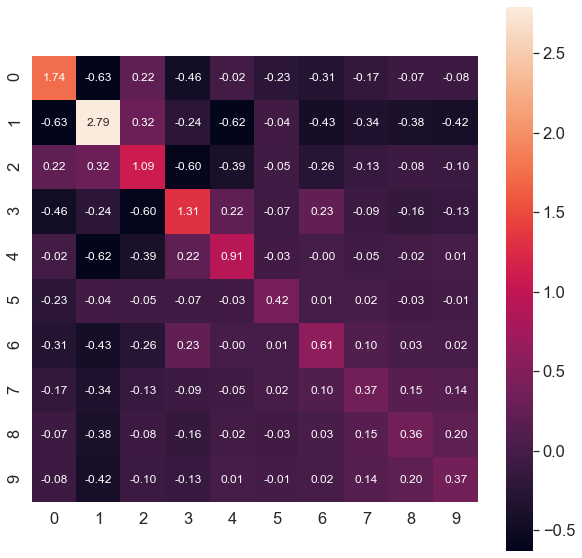

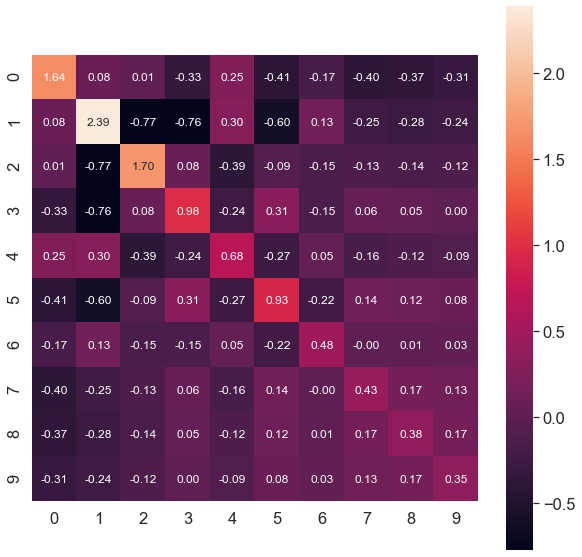

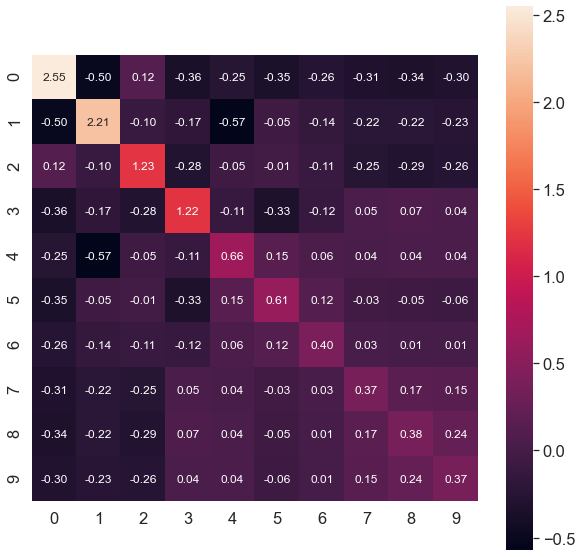

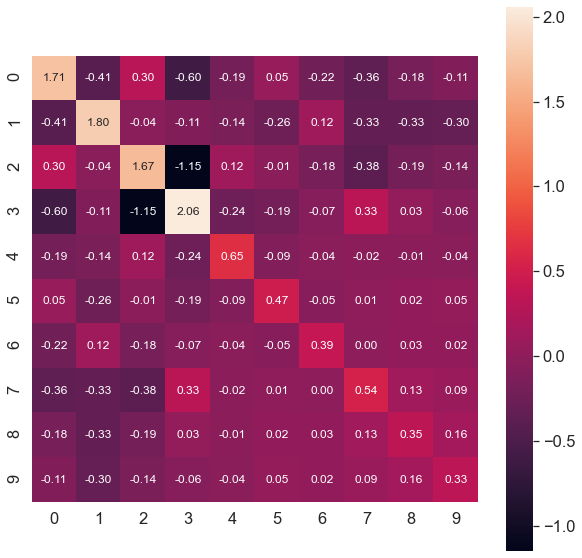

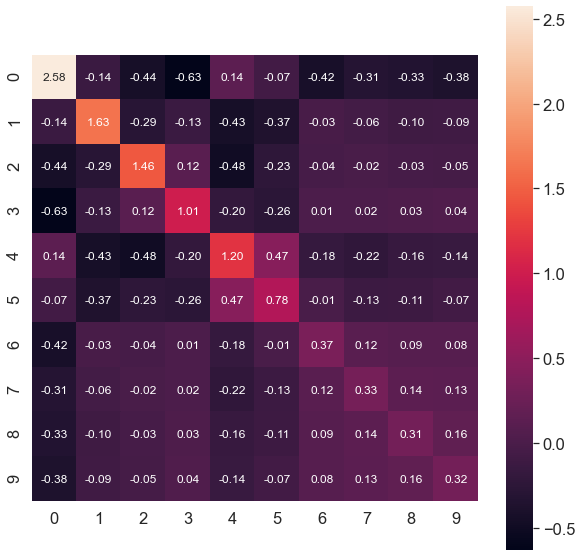

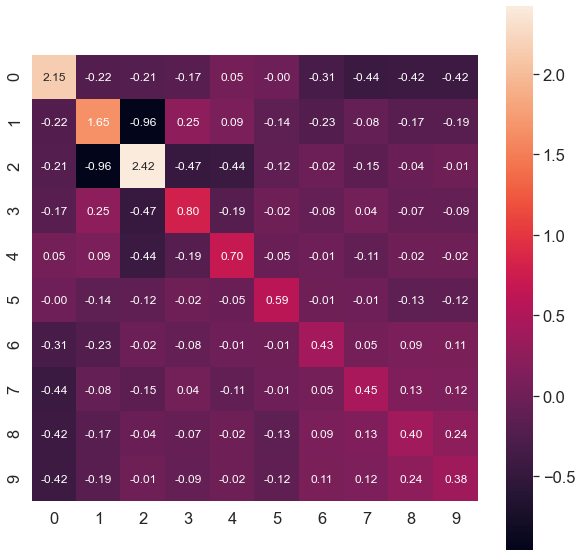

In [38]:
def compare_ensemble_indv_loss(true_zt, pred_zt, ts):
    means, stds = [], []
    for i in range(pred_zt.size(0)):
        rel_err = compute_rel_error(true_zt, pred_zt[i])
        err_geom_mean = compute_geom_mean(ts, rel_err)
        means.append(err_geom_mean.mean().item())
        stds.append(err_geom_mean.std().item())
    
    rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
    err_geom_mean = compute_geom_mean(ts, rel_err)
    means.append(err_geom_mean.mean().item())
    stds.append(err_geom_mean.std().item())
    
    errs = [s / 5. for s in stds]
    
    labels = [str(i) for i in range(pred_zt.size(0))] + ["ensemble"]

    x = np.arange(len(labels))
    width = 0.5

    plt.bar(x - width/2, means, width, yerr=errs)#, label="hnn-de")
    plt.xticks(x, labels)
    plt.legend()

    plt.show()
    plt.close()

def correlation_of_errs(true_zt, pred_zt):
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    scaled = StandardScaler().fit_transform(errs)
    cov = np.cov(scaled, rowvar=True)

    cols = [str(i) for i in range(len(cov))]
    plt.figure(figsize=cov.shape)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cov,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     yticklabels=cols,
                     xticklabels=cols)
    
    plt.show()
    plt.close()
    
def get_ensemble_loss(ensemble, z0, ts, true_zt):
    pred_zt = []
    for idx, model in enumerate(ensemble):
        print(idx)
        model = model.to("cpu")
        with torch.no_grad():
            pred = model.integrate(z0, ts, method='rk4')    
        pred_zt.append(pred)
    pred_zt = torch.stack(pred_zt, dim=0).cpu()
    
#     compare_ensemble_indv_loss(true_zt, pred_zt, ts)
#     correlation_of_errs(true_zt, pred_zt)
    
    num_models = pred_zt.size(0)
    errs = (true_zt - pred_zt).reshape(num_models, -1)
    
    rel_err = compute_rel_error(true_zt, pred_zt)
    err_geom_mean = compute_geom_mean(ts, rel_err)
    
    return err_geom_mean.mean(1), errs

z0 = true_zt[:,0]

means, errs = [], []
for epoch_step in range(40,50):
    save_fn = "ensemble_epoch_{}.pt".format(5 * epoch_step)
    
    ensemble_dict = torch.load(save_fn)
    trainer.ensemble.load_state_dict(ensemble_dict)
    
    geom_mean, _errs = get_ensemble_loss(trainer.ensemble, z0, ts, true_zt)
    
    means.append(geom_mean)
    errs.append(_errs)

means = torch.stack(means, dim=1)
errs = torch.stack(errs, dim=1)

T = means.size(1)
for i in range(means.size(0)):
    plt.plot(range(T), means[i], label=str(i))
plt.show()
plt.close()

for i in range(means.size(0)):
    scaled = StandardScaler().fit_transform(errs[i])
    cov = np.cov(scaled, rowvar=True)

    cols = [str(i) for i in range(len(cov))]
    plt.figure(figsize=cov.shape)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cov,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     yticklabels=cols,
                     xticklabels=cols)
    
    plt.show()
    plt.close()

In [24]:
true_zt.size()

torch.Size([25, 334, 2, 3, 2])

In [25]:
ts.size()

torch.Size([334])